# Project 1 - Multigrid 

In [49]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import matplotlib.pyplot as plt
import numpy.linalg as la

import time

from numba import jit


%matplotlib notebook

In [50]:
@jit
def linearize(x,y,m):
    return x+y*(m-2)

In [51]:
@jit
def delinearize(k,m):
    x = k%(m-2)
    y = k//(m-2)
    return (x,y)

In [52]:
@jit
def solve_triangular(A,x,b):
    sizeF = int(np.size(A,axis=0));
    for k in range(sizeF):
            x[k] = (b[k] - np.dot(A[k,0:k], x[0:k]) -np.dot(A[k,k+1:], x[k+1:]) ) / A[k,k];
    return x

In [1]:
@jit
def create_system(m):
    x = np.linspace(0,1,m)
    y = np.linspace(0,1,m)
    h_x = 1./(m-1)
    h_y = 1./(m-1)
    
    n_x = len(x)-2
    n_y = len(y)-2
    n = (n_x)*(n_y)
    A = np.zeros((n,n))
    b = np.zeros(n)
    for i in range(n_x):
        for j in range(n_y):
            index = linearize(i,j,m)
            if i==0 or i == n_x-1 or j == 0 or j == n_y -1:
                if i!= 0:
                    A[index, linearize(i-1,j,m)] = 1./(h_x**2) 
                if i != n_x-1:
                    A[index, linearize(i+1,j,m)] = 1./(h_x**2) 
                if j != 0:
                    A[index, linearize(i,j-1,m)] = 1./(h_y**2)
                if j != n_y-1:
                    A[index, linearize(i,j+1,m)] = 1./(h_x**2)
                A[index, linearize(i,j,m)] = -2 * (1./(h_x**2) + 1./(h_y**2))
            else:
                A[index, linearize(i-1,j,m)] = 1./(h_x**2)
                A[index, linearize(i+1,j,m)] = 1./(h_x**2)

                A[index, linearize(i,j,m)] = -2 * (1./(h_x**2) + 1./(h_y**2))

                A[index, linearize(i,j-1,m)] = 1./(h_y**2)
                A[index, linearize(i,j+1,m)] = 1./(h_x**2)

            b[index] =- 2 * ((1-6*x[i+1]**2)  
                             *y[j+1]**2 
                            *(1-y[j+1]**2) 
                            +(1-6*y[j+1]**2)
                            *x[i+1]**2 
                            *(1 - x[i+1]**2))

            
    return A,b

NameError: name 'jit' is not defined

In [54]:
@jit
def create_solution(m):
    x = np.linspace(0,1,m)
    y = np.linspace(0,1,m)
    
    n_x = len(x)-2
    n_y = len(y)-2
    u= np.zeros((n_x,n_y))
    for i,x_i in enumerate(x[1:-1]): 
        for j,y_j in enumerate(y[1:-1]):
            u[i,j] = (x_i**2-x_i**4)*(y_j**4-y_j**2)
    return u

In [55]:
def gauss_seidel(A,b,x,atol=1e-5, plot=False, iter_start = 0):             
    if plot:
        fig,ax = plt.subplots(1,1)
        shape = int(np.sqrt(x.shape[0]))
        shape = (shape,shape)
                 
    iterations = iter_start
    r = b - np.dot(A,x)
    
    L = np.tril(A)
    U = A - L
    while np.linalg.norm(r) > atol: 
        
        x = solve_triangular(L, x , b - np.dot(U,x))
        
        r = b - np.dot(A,x)
        
        iterations+=1
        
        if plot:
            x_show = x.reshape(shape)
            ax.set_title("Iteration: {}".format(iterations))
            ax.imshow(x_show)
            fig.canvas.draw()
                
    return x,iterations

In [56]:
tol = 1e-3
m = 4**3+2
A,b = create_system(m)
u = create_solution(m)

In [57]:
#np.random.seed(0)
#x_0 = np.random.rand(b.shape[0])
x_0 = np.zeros(b.shape[0])
v,iters = gauss_seidel(A,b,x_0,atol=tol, plot=False)

In [58]:
v = v.reshape(u.shape)

In [59]:
iters

4370

In [60]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(u)
ax1.set_title("Exact ($u$)")
ax2.imshow(v)
ax2.set_title("Approximated ($v$)")

<IPython.core.display.Javascript object>

In [61]:
def plot_vcycle(x,ax,fig, shape):
    x_show = x[:shape[0]**2].reshape(shape)
    ax.set_title("Resolution: {} x {}".format(shape[0],shape[1]))
    ax.imshow(x_show)
    fig.canvas.draw()

In [62]:
def create_p_vector( x, y, m):
    vect = np.zeros((m,m))
    
    vect[x,y] = 1/4.
    try:
        vect[x,y-1] = 1/8.
    except:
        pass
    
    try:
        vect[x,y+1] =1/8.
    except:
        pass
    
    try:
        vect[x-1,y] = 1/8.
    except:
        pass
    
    try:
        vect[x+1,y] = 1/8.
    except:
        pass
    
    try:
        vect[x-1,y-1] = 1/16.
    except:
        pass
    
    try:
        vect[x+1,y-1] = 1/16.
    except:
        pass
    
    try:
        vect[x-1,y+1] = 1/16.
    except:
        pass
    
    try:
        vect[x+1,y+1] = 1/16.
    except:
        pass
    
    return vect.flatten()

In [63]:
def _vcycle(A,b,x,m = None, v1=5, v2 = 5, plot=False, ax = None, fig = None):
    if not m:
        m = int(np.sqrt(b.shape[0])) + 2
        
    if plot and not ax and not fig:
        fig,ax = plt.subplots(1,1)
    shape = (m-2,m-2)
        

    
    # perform one v-cycle on the matrix A
    sizeF = int(A.shape[0]);
    # size for direct inversion < 15
    if sizeF < 14:
        x = la.solve(A,b)
        return x
    
    L = np.tril(A)
    U = A - L
    
    # v1=number of Gauss-Seidel iterations before coarsening
    for numGS in range(v1):
        x = solve_triangular(L,x,b - np.dot(U,x))
                
        if plot:
            plot_vcycle(x,ax,fig, shape) 

    # construct interpolation operator from next coarser to this mesh
    # next coarser has ((n-1)/2 + 1 ) points
    #assert(sizeF%2 ==1)
    sizeC = int((sizeF)/4)
    
    P = np.zeros((sizeF,sizeC));

    n = int(np.sqrt(sizeF))

    
    n_c = int(np.sqrt(sizeC))
    
    
    for a_c in range(n_c):
        for b_c in range(n_c):
            k = linearize(a_c,b_c, n_c+2)
            P[:,k] = create_p_vector(2*a_c, 2*b_c, n)

    # compute residual
    residual = b - np.dot(A,x)

    # project residual onto coarser mesh
    residC = np.dot(P.transpose(),residual)
    # Find coarser matrix (sizeC X sizeC)
    AC = np.dot(P.transpose(),np.dot(A,P))
    vC = _vcycle(AC,residC, np.zeros(sizeC), ax=ax, fig=fig,plot=plot);
    # extend to this mesh
    x = np.dot(P,vC)
    # v2=number of Gauss-Seidel iterations after coarsening
    for numGS in range(v2):
        x = solve_triangular(L,x,b - np.dot(U,x))
        
        if plot:
            plot_vcycle(x,ax,fig, shape) 
        
    return x

In [64]:
def vcycle(A,b,x, v1=2,v2=2,plot=False,atol=1e-3):
    r = la.norm(b - np.dot(A,x))
    iters = 0
    
    if plot:
        fig,ax = plt.subplots(1,1)
    else:
        fig, ax = (None,None)
        
    while r > atol:
        x = _vcycle(A,b,x,v1=v1,v2=v2, plot=plot, fig=fig,ax=ax)
        r = la.norm(b - np.dot(A,x))
        print(r)
        iters +=1
    return x,iters

<IPython.core.display.Javascript object>


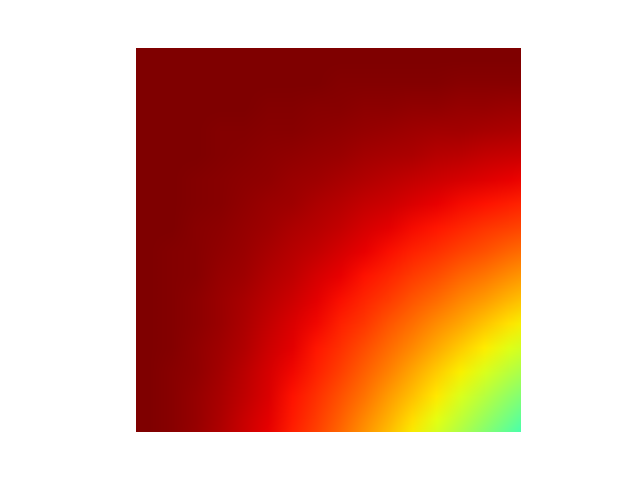

21.9274386672
52.6131435853
32.5887160233


KeyboardInterrupt: 

In [65]:
r = 1
v = np.zeros(b.shape[0]);

v,iters = vcycle(A,b,v,v1=2,v2=2, plot=True)

v = v.reshape(u.shape)

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(u)
ax1.set_title("Exact ($u$)")
ax2.imshow(v)
ax2.set_title("Approximated ($v$)")